In [3]:
import os, sys
sys.path.append('../deep_dream_src/')
import pandas as pd 
from group_selfies import GroupGrammar
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, split_dataframe
from utils import *
import pickle
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, spearmanr
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import torch

In [4]:
def parity_plot(y_test: np.array, y_pred: np.array, target: str, ax, style='gaussian',scale='linear'):
    """Plots the predictions of a model against the true values.
    
    Args:
        y_test (numpy.ndarray): The true values of the test set.
        y_pred (numpy.ndarray): The predicted values of the test set.

    Returns:
        None
    """
    
    # Calculate the point density using a Gaussian kernel density estimation
    if style == 'gaussian':
        xy = np.vstack([y_test, y_pred])
        density = gaussian_kde(xy)(xy)
        ax.scatter(y_test, y_pred,s=5,c=density,cmap='viridis')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=1)
    elif style == 'hexbin':
        ax.hexbin(y_test, y_pred, gridsize=30,cmap='magma_r', mincnt=1)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=1)

    ax.set(xlabel=f'Actual {target}',ylabel=f'Predicted {target}',
        )
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    ax.set_xlim([y_test.min(), y_test.max()])
    ax.set_ylim([y_test.min(), y_test.max()])
    
    # Add text box with SRCC, MAE, and RMAE values
    text_box = f'R2: {r2_score(y_test,y_pred):.2f}\nSRCC: {spearmanr(y_test,y_pred)[0]:.2f}\nMAE: {mean_absolute_error(y_test,y_pred):.2f}'
    ax.text(0.05, 0.95, text_box, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left')


def create_parity_plot(model, scaler, test_loader,target, ax, style='gaussian'):
    """
    Create a parity plot to visualize the model's predictions against the actual target values.

    Args:
        model (torch.nn.Module): The trained model.
        scaler (sklearn.preprocessing.StandardScaler): The scaler used to normalize the data.
        test_loader (torch.utils.data.DataLoader): The data loader for the test dataset.

    Returns:
        None
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device
    model.eval()

    outputs, test_targets = [], []
    with torch.no_grad():
        for i, (onehot_input, embedding_input, target_values) in enumerate(test_loader):
            # Move input tensors to the same device as the model
            onehot_input = onehot_input.to(device)
            target_values = target_values.to(device)

            if type(embedding_input) == list:
                embedding_input = torch.stack(embedding_input, dim=0).squeeze().unsqueeze(0)
            embedding_input = embedding_input.to(device)

            output = model(onehot_input, embedding_input)
            rescaled_output = scaler.inverse_transform(output.cpu().reshape(-1,1))  # Move output back to CPU f$
            outputs.extend(rescaled_output.reshape(-1).tolist())
            test_targets.extend(scaler.inverse_transform(target_values.cpu().reshape(-1,1)).reshape(-1).tolist())

    parity_plot(np.array(test_targets), np.array(outputs), target, ax, style='hexbin',scale='linear')

In [6]:
training_data = pd.read_csv('./training_data.csv')
group_grammar = GroupGrammar.from_file('./gs_mof_grammar.txt')

In [7]:
target_names = ['GSA','totalPOV_VF','cp','bandgap','log_CO2_N2_selectivity', 'heat_of_adsorption_CO2_300_kJ_mol']
titles = ['GSA ($\mathregular{m^2\ g^{-1}}$)', 'VF (-)', '$c_p$ ($\mathregular{J\ g^{-1}\ K^{-1}}$)', 'bandgap (eV)', 'ln($S_{CO_2/N_2}$)', '$Q_{CO_2}$ ($\mathregular{kJ\ mol^{-1}}$)']

../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

(1000, 1)
(1000, 1)


../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

(1000, 1)
(1000, 1)


../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

(1000, 1)
(1000, 1)


../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

(1000, 1)
(1000, 1)


../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

(1000, 1)
(1000, 1)


../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

(1000, 1)
(1000, 1)


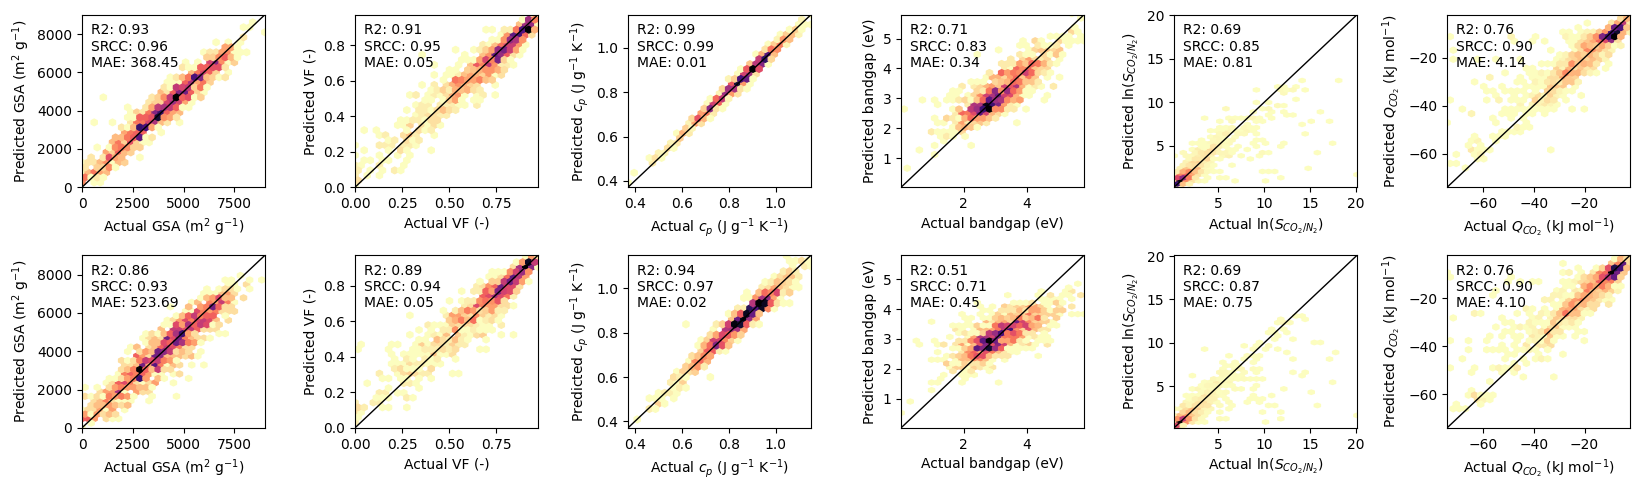

In [12]:
fig,ax=plt.subplots(2,6,figsize=(16.5,5))
ax = ax.flatten()
for i in range(len(target_names)):
    target_name = [target_names[i]]
    title = titles[i] 
    mof_selfies_encoding, tokenized_info = featurize_df(
        training_data,
        target_name,
        edge_rep = 'edge_group_selfie',
        node_rep = 'node_selfie',
        topo_rep = 'topo'
        )

    samples = 10000
    split_by = {
        'method': 'sample',
        'train': samples,
        'validate': 1000,
        'test': 1000
        }

    train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

    model_name = f'LSTM_interval_noise_06_{target_name[0]}_11000samples_group_selfies'
    with open('./mof_saved_models/{}.pkl'.format(model_name), 'rb') as f:
        dream_train_info = pickle.load(f)
    scaler = dream_train_info['scaler']
    tokenized_info = dream_train_info['tokenized_info']
    dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
    dream_hyperparams = dream_train_info['hyperparams']

    model_name = f'LSTM_interval_noise_00_{target_name[0]}_11000samples_group_selfies'
    with open('./mof_saved_models/{}.pkl'.format(model_name), 'rb') as f:
        predictor_train_info = pickle.load(f)
    predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
    predictor_hyperparams = predictor_train_info['hyperparams']

    dreaming_model = MolecularLSTMModel(**dream_hyperparams)
    dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
    predictor_model = MolecularLSTMModel(**predictor_hyperparams)
    predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

    dreaming_validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_name,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=scaler,noise_level=dream_train_info['noise_level'])
    predictor_validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_name,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=scaler,noise_level=None)
    create_parity_plot(predictor_model, scaler, predictor_validate_loader,title,ax[i])
    create_parity_plot(dreaming_model, scaler, dreaming_validate_loader,title,ax[i+6])

fig.tight_layout()

In [13]:
fig.savefig('parity_plots.png',dpi=500)